In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import utils_v2 as utils
import pickle
import random

In [ ]:
with open('graph_objects/G_simple_directed.pickle', 'rb') as f:
    G_simple_directed = pickle.load(f)
    G_simple_directed.name = 'G_simple_directed'

----
# N-k MAX FLOW 

In [ ]:
def W(G, global_nodes_lst):
    """
    Computes all-pairs flow matrix W of the network.
    
    Parameters:
        G: A NetworkX MultiDiGraph

    Returns:
        flow_matrix: 2D numpy array representing the flow matrix
        node_indices: Dictionary mapping nodes to their corresponding indices
    """
    num_nodes = len(global_nodes_lst)
    node_indices = {node: i for i, node in enumerate(global_nodes_lst)}
    flow_matrix = np.zeros((num_nodes, num_nodes))

    tot_flow = 0
    for i in tqdm(range(num_nodes), desc="Computing flow matrix W"):

        source = global_nodes_lst[i]

        for j in range(num_nodes):

            sink = global_nodes_lst[j]

            if source != sink and source in G and sink in G:
                if nx.has_path(G, source, sink):
                    flow_val, flow_dict = nx.maximum_flow(G, source, sink, capacity="max_cap_M_m3_per_d", flow_func=nx.algorithms.flow.dinitz)

                    flow_matrix[i, j] = flow_val
                    tot_flow += flow_val
            else:
                flow_matrix[i, j] = 0           

    return flow_matrix, node_indices, tot_flow / num_nodes


def W_c(_flow_matrix, target, node_indices):
    """
    Computes the flow matrix W_c after removing a node.
    Defined in Cai et al. (2021) as the original flow matrix of the network after removing entry corresponding to the removed node.

    Parameters:
        flow_matrix: Flow matrix of the original graph
        target: Target can be either a single node or an edge in the form (v1, v2)
        node_indices: Dictionary mapping nodes to their indices in the flow matrix

    Returns:
        flow_matrix_c: Flow matrix after removing the specified node
        flow_matrix: Modified flow matrix
    """

    flow_matrix = _flow_matrix.copy()

    if isinstance(target, (set,tuple)) and len(target) == 2:
        # Target is an edge in the form (v1, v2)
        v1, v2 = target
        index_v1 = node_indices.get(v1, None)
        index_v2 = node_indices.get(v2, None)

        if index_v1 is not None and index_v2 is not None:
            flow_matrix[index_v1, index_v2] = 0
            flow_matrix[index_v2, index_v1] = 0
    
    else:
        removed_node_index = node_indices.get(target, None)

        if removed_node_index is not None and removed_node_index < flow_matrix.shape[0]:
            flow_matrix = np.delete(flow_matrix, removed_node_index, axis=0)
            flow_matrix = np.delete(flow_matrix, removed_node_index, axis=1)

    return flow_matrix

In [ ]:
def flow_capacity_robustness(G_, heuristic='random', remove='node', k_removals=150, n_benchmarks = 20, flow_func=nx.algorithms.flow.dinitz):
    """ 
    Computes the n-k capacity robustness based on maximum flow of a graph
    """

    # Make a copy of the graph
    G = G_.copy()
    
    # Instantiate list of all nodes in the graph
    global_nodes_lst = list(G.nodes())

    # Get all-pairs flow matrix W of the network
    flow_matrix, node_indices, flow_val_init = W(G, global_nodes_lst)

    # Instantiate the results dataframe
    results_df = pd.DataFrame(columns=['max_flow_value', 'capacity_robustness_max_flow', 'heuristic', 'removed_entity'])
    results_df.loc[0] = [flow_val_init, 1, None, None]


    # Helper function to perform a targeted removal   
    def perform_targeted_removal(G, heuristic, target, flow_matrix, _node_indices, results_df):
        
        if remove == 'edge':
            G.remove_edge(*target)
        else:
            target = target[0]
            G.remove_node(target)

        # Calculate the flow matrix W_c after removing the node or edge
        W_c_ = W_c(flow_matrix, target, _node_indices)

        W_c_prime, node_indices, current_flow_val = W(G, global_nodes_lst)

        target = target if remove == 'node' else set(target)

        results_df.loc[k] = [current_flow_val, np.sum(W_c_prime) / np.sum(W_c_), heuristic, target]

        return G, W_c_, node_indices

    # Heuristic specific initializations
    if heuristic == 'random':
        G_lst = [G.copy() for _ in range(n_benchmarks)]
        G_node_indices_lst = [node_indices.copy() for _ in range(n_benchmarks)]
        G_flow_matrix_lst = [flow_matrix for _ in range(n_benchmarks)]

    observed_min_cutset_edge_counts = {}

    # N-k capacity robustness calculation
    for k in tqdm(range(1, k_removals + 1), desc='N-k capacity robustness'):

        if heuristic == 'random':

            max_flow_lst, capacity_robustness_lst = [], []

            for G_copy, G_flow_matrix, G_node_indices in zip(G_lst, G_flow_matrix_lst, G_node_indices_lst):

                # Get a random target to remove
                target = random.choice([target for target in (G_copy.nodes() if remove == 'node' else G_copy.edges())])
                G_copy.remove_edge(*target) if remove == 'edge' else G_copy.remove_node(target)
                
                # Calculate W_c and W_c_prime after removing the node or edge
                G_flow_matrix = W_c(G_flow_matrix, target, G_node_indices)
                G_W_c_prime, G_node_indices, current_flow_val = W(G_copy, global_nodes_lst)

                # Append the results to the lists for the current iteration
                capacity_robustness_lst.append(np.sum(G_W_c_prime) / np.sum(G_flow_matrix))
                max_flow_lst.append(current_flow_val)
            
            target = target if remove == 'node' else set(target)
            results_df.loc[k] = [np.mean(max_flow_lst), np.mean(capacity_robustness_lst), 'random', target]
        
        elif heuristic == 'load_rate':
            target_df = utils.max_flow_edge_count(G, count_or_flow='load_rate')

            if target_df.empty:
                return results_df
                    
            G, flow_matrix, node_indices = perform_targeted_removal(G, 'load_rate', target_df.iloc[0].edge, flow_matrix, node_indices, results_df)
        

        elif heuristic == 'max_flow_edge_count':
            target_df = utils.max_flow_edge_count(G)

            if target_df.empty:
                return results_df
                    
            G, flow_matrix, node_indices = perform_targeted_removal(G, 'max_flow_edge_count', target_df.iloc[0].edge, flow_matrix, node_indices, results_df)

        elif heuristic == 'max_flow':
            target_df = utils.max_flow_edge_count(G, count_or_flow='flow')

            if target_df.empty:
                return results_df
                    
            G, flow_matrix, node_indices = perform_targeted_removal(G, 'max_flow_edge_flows', target_df.iloc[0].edge, flow_matrix, node_indices, results_df)   

        elif heuristic == 'min_cutset_edge_count':
            target_df, observed_min_cutset_edge_counts = utils.edge_cutset_count(G, observed_min_cutset_edge_counts.copy(), k)

            if target_df.empty:
                return results_df

            G, flow_matrix, node_indices = perform_targeted_removal(G, 'min_cutset_edge_count', target_df.iloc[0].edge, flow_matrix, node_indices, results_df)

        elif heuristic == 'wfcr':
            target_df = utils.weighted_flow_capacity_rate(G)

            if target_df.empty:
                return results_df

            G, flow_matrix, node_indices = perform_targeted_removal(G, 'wfcr', target_df.iloc[0].edge, flow_matrix, node_indices, results_df)


        else:
            raise ValueError("Invalid heuristic")


    return results_df

----
# Heuristics

### Node removal

In [ ]:
""" random_node_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='random', remove='node')
random_node_removal_df.to_pickle('results/max_flow/all_pairs_flow_index_v2/random_node_removal_df.pkl')
random_node_removal_df = pd.read_pickle('results/max_flow/all_pairs_flow_index_v2/random_node_removal_df.pkl') """

In [ ]:
"""
146m 
"""
load_rate_node_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='load_rate', remove='node')
load_rate_node_removal_df.to_pickle('results/max_flow/all_pairs_flow_index_v2/load_rate_node_removal_df.pkl')
load_rate_node_removal_df = pd.read_pickle('results/max_flow/all_pairs_flow_index_v2/load_rate_node_removal_df.pkl')
utils.results_summary(load_rate_node_removal_df)

Heuristic: load_rate

First entity removals:
----------------------------------------------
 it removed_entity   diff  pct_change
  1    INET_N_1637 226.03       -21.0
  2    INET_N_1146   7.62        -0.9
  3     INET_N_698  13.31        -1.6
  4     INET_N_243  15.26        -1.8
  5     INET_N_987  29.54        -3.6

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it removed_entity   diff  pct_change
  1    INET_N_1637 226.03       -21.0
 28    INET_N_1570  58.64        -9.9
135     INET_N_435  42.16       -18.5
 39    INET_N_1428  42.12        -9.4
 36     INET_N_151  39.00        -7.9


Summary statistics (first 150 removals)
----------------------------------------------
Percentage network damage: 84.4%
Mean damage per entity removal: 81.59
Variation in damage per entity removal: 81.11


In [ ]:
"""
129m
"""
max_flow_node_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='max_flow', remove='node')
max_flow_node_removal_df.to_pickle('results/max_flow/all_pairs_flow_index_v2/max_flow_node_removal_df.pkl')
max_flow_node_removal_df = pd.read_pickle('results/max_flow/all_pairs_flow_index_v2/max_flow_node_removal_df.pkl')
utils.results_summary(max_flow_node_removal_df)

Heuristic: max_flow_edge_flows

First entity removals:
----------------------------------------------
 it removed_entity   diff  pct_change
  1     INET_N_572 218.67       -20.3
  2     INET_N_987  38.36        -4.5
  3     INET_N_243  15.26        -1.9
  4     INET_N_968   4.45        -0.6
  5     INET_N_580  24.65        -3.1

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it removed_entity   diff  pct_change
  1     INET_N_572 218.67       -20.3
  8     INET_N_741 109.80       -15.6
  6    INET_N_1545  65.97        -8.5
 75     INET_N_435  43.77       -14.5
  2     INET_N_987  38.36        -4.5


Summary statistics (first 150 removals)
----------------------------------------------
Percentage network damage: 87.7%
Mean damage per entity removal: 95.31
Variation in damage per entity removal: 74.48


In [ ]:
"""
144m 
"""
max_flow_edge_count_node_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='max_flow_edge_count', remove='node')
max_flow_edge_count_node_removal_df.to_pickle('results/max_flow/all_pairs_flow_index_v2/max_flow_edge_count_node_removal_df.pkl')
max_flow_edge_count_node_removal_df = pd.read_pickle('results/max_flow/all_pairs_flow_index_v2/max_flow_edge_count_node_removal_df.pkl')
utils.results_summary(max_flow_edge_count_node_removal_df)

Heuristic: max_flow_edge_count

First entity removals:
----------------------------------------------
 it removed_entity   diff  pct_change
  1     INET_N_958 127.13       -11.8
  2     INET_N_987  75.32        -7.9
  3    INET_N_1469  11.70        -1.3
  4     INET_N_243  15.26        -1.8
  5     INET_N_881   1.73        -0.2

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it removed_entity   diff  pct_change
  1     INET_N_958 127.13       -11.8
  2     INET_N_987  75.32        -7.9
  6    INET_N_1250  66.66        -7.9
 11    INET_N_1570  60.81        -8.4
 39    INET_N_1620  57.30       -12.3


Summary statistics (first 150 removals)
----------------------------------------------
Percentage network damage: 84.0%
Mean damage per entity removal: 77.44
Variation in damage per entity removal: 28.6


In [ ]:
"""
126m
"""
wfcr_node_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='wfcr', remove='node')
wfcr_node_removal_df.to_pickle('results/max_flow/all_pairs_flow_index_v2/wfcr_node_removal_df.pkl')
wfcr_node_removal_df = pd.read_pickle('results/max_flow/all_pairs_flow_index_v2/wfcr_node_removal_df.pkl')
utils.results_summary(wfcr_node_removal_df)

Heuristic: wfcr

First entity removals:
----------------------------------------------
 it removed_entity   diff  pct_change
  1    INET_N_1035 224.19       -20.8
  2    INET_N_1600   9.21        -1.1
  3     INET_N_243  15.26        -1.8
  4     INET_N_912  44.43        -5.4
  5     INET_N_580  24.65        -3.1

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it removed_entity   diff  pct_change
  1    INET_N_1035 224.19       -20.8
  9    INET_N_1199 109.99       -16.1
  6    INET_N_1545  69.00        -9.1
 10     INET_N_889  54.63        -9.5
  4     INET_N_912  44.43        -5.4


Summary statistics (first 150 removals)
----------------------------------------------
Percentage network damage: 87.2%
Mean damage per entity removal: 100.45
Variation in damage per entity removal: 73.53


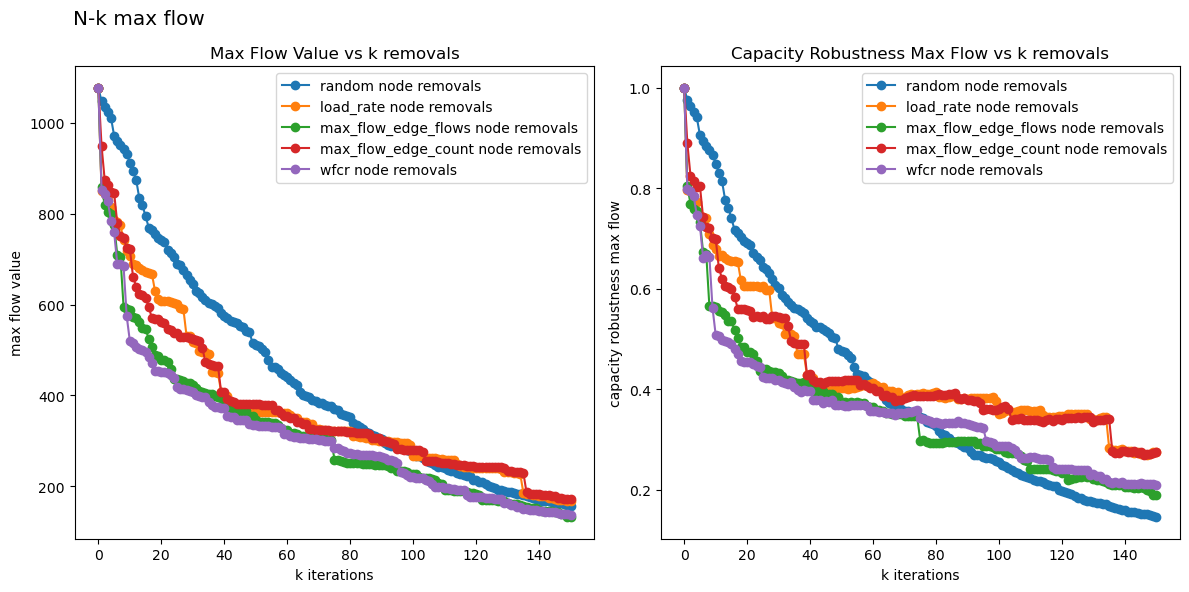

In [ ]:
utils.plot_heuristic_comparison_biplot([load_rate_node_removal_df, max_flow_node_removal_df, max_flow_edge_count_node_removal_df, wfcr_node_removal_df], 'N-k max flow')

### Edge removal

In [ ]:
""" random_edge_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='random', remove='edge')
random_edge_removal_df.to_pickle('results/max_flow/all_pairs_flow_index/random_edge_removal_df.pkl')
random_edge_removal_df = pd.read_pickle('results/max_flow/all_pairs_flow_index/random_edge_removal_df.pkl') """

" random_edge_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='random', remove='edge')\nrandom_edge_removal_df.to_pickle('results/max_flow/all_pairs_flow_index/random_edge_removal_df.pkl')\nrandom_edge_removal_df = pd.read_pickle('results/max_flow/all_pairs_flow_index/random_edge_removal_df.pkl') "

In [ ]:
"""
215m 
"""
load_rate_edge_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='load_rate', remove='edge')
load_rate_edge_removal_df.to_pickle('results/max_flow/all_pairs_flow_index_v2/load_rate_edge_removal_df.pkl')
load_rate_edge_removal_df = pd.read_pickle('results/max_flow/all_pairs_flow_index_v2/load_rate_edge_removal_df.pkl')
utils.results_summary(load_rate_edge_removal_df) 

Heuristic: load_rate

First entity removals:
----------------------------------------------
 it             removed_entity   diff  pct_change
  1 {INET_N_1637, INET_N_1620} 222.14       -20.6
  2  {INET_N_1146, INET_N_912}   4.82        -0.6
  3   {INET_N_426, INET_N_698}   0.08        -0.0
  4  {INET_N_1447, INET_N_898}  12.40        -1.5
  5    {INET_N_72, INET_N_243}  12.49        -1.5

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it             removed_entity   diff  pct_change
  1 {INET_N_1637, INET_N_1620} 222.14       -20.6
 27 {INET_N_1570, INET_N_1263}  60.78        -9.2
 10  {INET_N_561, INET_N_1609}  32.60        -4.1
 28    {N_dolyna, INET_N_1545}  25.99        -4.3
 24  {INET_N_958, INET_N_1623}  23.52        -3.4


Summary statistics (first 150 removals)
----------------------------------------------
Percentage network damage: 65.0%
Mean damage per entity removal: 73.01
Variation in damage per entity remo

In [ ]:
"""
220m 
"""
max_flow_edge_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='max_flow', remove='edge')
max_flow_edge_removal_df.to_pickle('results/max_flow/all_pairs_flow_index_v2/max_flow_edge_removal_df.pkl')
max_flow_edge_removal_df = pd.read_pickle('results/max_flow/all_pairs_flow_index_v2/max_flow_edge_removal_df.pkl')
utils.results_summary(max_flow_edge_removal_df)

Heuristic: max_flow_edge_flows

First entity removals:
----------------------------------------------
 it            removed_entity   diff  pct_change
  1 {INET_N_572, INET_N_1333} 214.78       -20.0
  2 {INET_N_987, INET_N_1451}  34.01        -3.9
  3   {INET_N_72, INET_N_243}  12.49        -1.5
  4  {INET_N_692, INET_N_968}   4.06        -0.5
  5 {INET_N_1447, INET_N_982}  15.99        -2.0

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it            removed_entity   diff  pct_change
  1 {INET_N_572, INET_N_1333} 214.78       -20.0
 10 {INET_N_1605, INET_N_358}  68.70        -8.7
 11 {INET_N_741, INET_N_1199}  46.46        -6.4
  2 {INET_N_987, INET_N_1451}  34.01        -3.9
120  {INET_N_435, INET_N_889}  32.73        -8.2


Summary statistics (first 150 removals)
----------------------------------------------
Percentage network damage: 74.6%
Mean damage per entity removal: 79.34
Variation in damage per entity remova

In [ ]:
"""
235m 
"""
max_flow_edge_count_edge_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='max_flow_edge_count', remove='edge')
max_flow_edge_count_edge_removal_df.to_pickle('results/max_flow/all_pairs_flow_index_v2/max_flow_edge_count_edge_removal_df.pkl')
max_flow_edge_count_edge_removal_df = pd.read_pickle('results/max_flow/all_pairs_flow_index_v2/max_flow_edge_count_edge_removal_df.pkl')
utils.results_summary(max_flow_edge_count_edge_removal_df)

Heuristic: max_flow_edge_count

First entity removals:
----------------------------------------------
 it            removed_entity   diff  pct_change
  1  {INET_N_958, INET_N_475} 123.24       -11.4
  2 {INET_N_987, INET_N_1451}  69.29        -7.3
  3 {INET_N_1287, INET_N_708}   8.08        -0.9
  4 {INET_N_161, INET_N_1627}  51.35        -5.9
  5   {INET_N_72, INET_N_243}  12.49        -1.5

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it             removed_entity   diff  pct_change
  1   {INET_N_958, INET_N_475} 123.24       -11.4
  2  {INET_N_987, INET_N_1451}  69.29        -7.3
  6  {INET_N_1556, INET_N_135}  67.28        -8.3
  4  {INET_N_161, INET_N_1627}  51.35        -5.9
149 {INET_N_1149, INET_N_1037}  37.98        -8.3


Summary statistics (first 150 removals)
----------------------------------------------
Percentage network damage: 61.3%
Mean damage per entity removal: 69.83
Variation in damage per entity 

In [ ]:
"""
226m 
"""
wfcr_edge_removal_df = flow_capacity_robustness(G_simple_directed, heuristic='wfcr', remove='edge')
wfcr_edge_removal_df.to_pickle('results/max_flow/all_pairs_flow_index_v2/wfcr_edge_removal_df.pkl')
wfcr_edge_removal_df = pd.read_pickle('results/max_flow/all_pairs_flow_index_v2/wfcr_edge_removal_df.pkl')
utils.results_summary(wfcr_edge_removal_df) 

Heuristic: wfcr

First entity removals:
----------------------------------------------
 it             removed_entity   diff  pct_change
  1 {INET_N_1637, INET_N_1035} 220.30       -20.5
  2  {INET_N_987, INET_N_1600}   7.83        -0.9
  3    {INET_N_72, INET_N_243}  12.49        -1.5
  4   {INET_N_987, INET_N_912}  23.62        -2.8
  5   {INET_N_580, INET_N_982}  19.59        -2.4

Entity removals causing most damage, measured by: max_flow_value
----------------------------------------------
 it             removed_entity   diff  pct_change
  1 {INET_N_1637, INET_N_1035} 220.30       -20.5
  9   {INET_N_741, INET_N_889}  73.27        -9.3
 43   {INET_N_589, INET_N_151}  43.33        -7.7
117   {INET_N_435, INET_N_889}  34.09        -8.9
 21   {INET_N_138, INET_N_416}  32.01        -5.0


Summary statistics (first 150 removals)
----------------------------------------------
Percentage network damage: 73.0%
Mean damage per entity removal: 80.6
Variation in damage per entity removal: 7

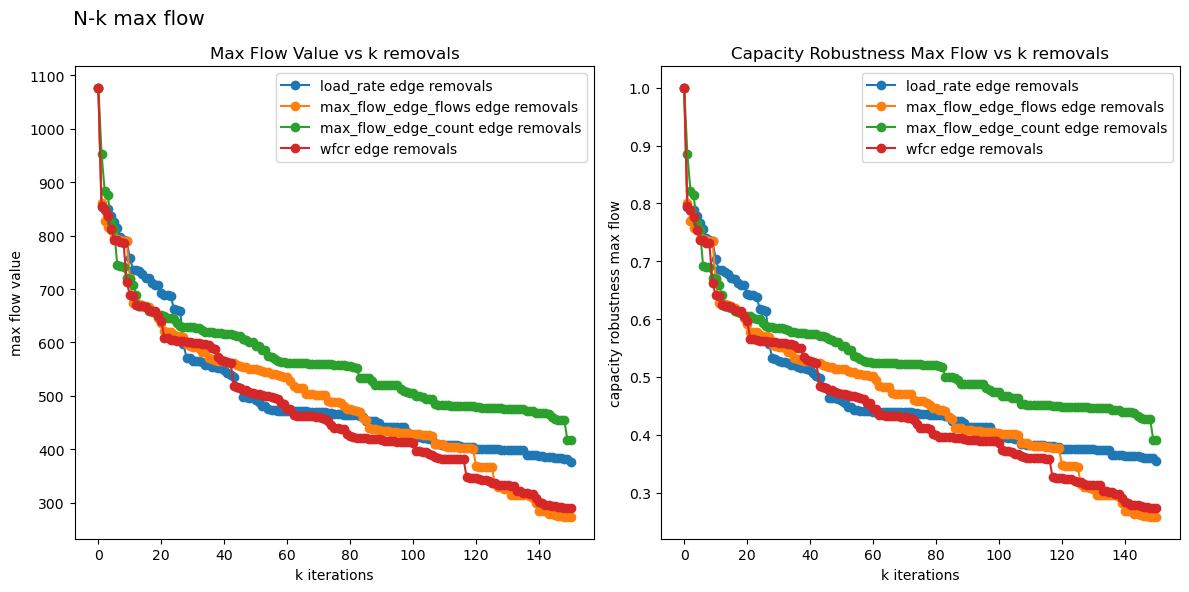

In [ ]:
utils.plot_heuristic_comparison_biplot([load_rate_edge_removal_df, max_flow_edge_removal_df, max_flow_edge_count_edge_removal_df, wfcr_edge_removal_df], 'N-k max flow')